In [108]:
from polyglot.text import Text

import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map

from utils import *

from nltk import ngrams
import nltk

import scipy
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## POS CZ data

In [2]:
def extract_features_cz(txt):
    
    doc = Text(txt, hint_language_code='cs')

    txt_pos = []
    
    for token in doc.pos_tags:
        if token[1] not in ['SPACE', 'PUNCT']:
            txt_pos.append(token[1])            
    
    return txt_pos

In [6]:
df_cz_cz = pd.read_csv('../datasets/demagog_nlp_cz/converted-exp-CZ.tsv', sep='\t')

df_cz_cz['text_clean'] = df_cz_cz['statementText'].apply(lambda x: clean_przyp(x))

tasks = df_cz_cz['text_clean'].values.tolist()
result = progress_map(extract_features_cz, tasks, n_cpu=7, chunk_size=1, core_progress=True)

Core 1:   0%|          | 0/1298 [00:00<?, ?it/s]

Core 2:   0%|          | 0/1298 [00:00<?, ?it/s]

Core 3:   0%|          | 0/1298 [00:00<?, ?it/s]

Core 4:   0%|          | 0/1298 [00:00<?, ?it/s]

Core 5:   0%|          | 0/1298 [00:00<?, ?it/s]

Core 6:   0%|          | 0/1298 [00:00<?, ?it/s]

Core 7:   0%|          | 0/1298 [00:00<?, ?it/s]

In [7]:
df_cz_cz['TEXT_POS'] = result

df_cz_cz['TEXT_POS'] = df_cz_cz['TEXT_POS'].str.join(" ")

In [8]:
df_cz_cz['TEXT_POS']

0       PROPN PROPN PROPN PROPN NOUN PROPN NOUN ADP PR...
1       PROPN PROPN PROPN ADV PROPN PROPN CONJ PROPN P...
2       PROPN PRON NOUN PROPN PROPN PROPN PROPN PROPN ...
3       PROPN PROPN PROPN PROPN PRON PRON PROPN PROPN ...
4       PART ADV PROPN ADP PROPN PROPN PROPN PROPN PRO...
                              ...                        
9077                           PRON PROPN PROPN ADP PROPN
9078    PROPN PRON PROPN CONJ NOUN PROPN PROPN NOUN PR...
9079    PRON PROPN PROPN PRON PRON PROPN ADP NOUN NOUN...
9080    PROPN PRON PROPN ADJ NOUN PROPN ADJ NOUN ADP N...
9081    PROPN DET ADJ NOUN PROPN CONJ ADJ NOUN ADJ NUM...
Name: TEXT_POS, Length: 9082, dtype: object

In [9]:
df_cz_cz.to_csv('../datasets/ready2use/fake_news_features_cz_CZ.csv', sep=';', index=False, encoding='utf8')

In [11]:
df_cz_cz.shape

(9082, 10)

In [18]:
df['statementState'].unique()

array(['TRUE', 'UNVERIFIABLE', 'FALSE', 'MISLEADING', 'null'],
      dtype=object)

In [127]:
df_cz_cz['statementState'] = df_cz_cz['statementState'].str.strip()

df_cz_cz = df_cz_cz[ df_cz_cz['statementState'] != 'MISLEADING' ]
df_cz_cz = df_cz_cz[ df_cz_cz['statementState'] != 'UNVERIFIABLE' ]
df_cz_cz = df_cz_cz[ df_cz_cz['statementState'] != 'null' ]

df_cz = df_cz_cz.reset_index(drop=True)

df_cz['assestment'] = df_cz['statementState'].replace({
    'FALSE' : 0,
#     'Manipulacja' : 1,
    'TRUE' : 1
}).astype(int)

## POS ENG data

In [26]:
nlp_core_en = spacy.load("en_core_web_lg")

In [47]:
df_en = pd.concat(
[
    pd.read_csv('../datasets/liar/train.tsv', sep='\t', header=None),
    pd.read_csv('../datasets/liar/valid.tsv', sep='\t', header=None),
    pd.read_csv('../datasets/liar/test.tsv', sep='\t', header=None)
]
).iloc[:,:3]

df_en.columns = [
    'id',
    'label',
    'statement'
]

df_en.loc[:, 'label'] = df_en['label'].replace({
    'half-true' : 'true',
    'mostly-true' : 'true',
    'barely-true' : 'false',
    'pants-fire' : 'false',
})

In [48]:
df_en['label'].value_counts()

true     7134
false    5657
Name: label, dtype: int64

In [61]:
def extract_features_en(txt, nlp_core=nlp_core_en):
    
    doc = nlp_core(txt)
    
    txt_pos = []
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            txt_pos.append(token.pos_)            
    
    return txt_pos

In [62]:
df_en['text_clean'] = df_en['statement'].apply(lambda x: clean_przyp(x))

tasks = df_en['text_clean'].values.tolist()
result = progress_map(extract_features_en, tasks, n_cpu=7, chunk_size=1, core_progress=True)

Core 1:   0%|          | 0/1828 [00:00<?, ?it/s]

Core 2:   0%|          | 0/1828 [00:00<?, ?it/s]

Core 3:   0%|          | 0/1828 [00:00<?, ?it/s]

Core 4:   0%|          | 0/1828 [00:00<?, ?it/s]

Core 5:   0%|          | 0/1828 [00:00<?, ?it/s]

Core 6:   0%|          | 0/1828 [00:00<?, ?it/s]

Core 7:   0%|          | 0/1828 [00:00<?, ?it/s]

In [63]:
df_en['TEXT_POS'] = result

df_en['TEXT_POS'] = df_en['TEXT_POS'].str.join(" ")

In [64]:
df_en.columns

Index(['id', 'label', 'statement', 'text_clean', 'TEXT_POS'], dtype='object')

## Use EN/CZ data as training

In [65]:
df_en['assestment'] = df_en['label'].replace({
    'false' : 0,
#     'Manipulacja' : 1,
    'true' : 1
}).astype(int)

y_train = df_en.copy()['assestment']
X_train = df_en.copy()[['TEXT_POS']]

In [128]:
y_train = df_cz.copy()['assestment']
X_train = df_cz.copy().loc[:, df_cz.columns != 'assestment']

In [129]:
n_grams = 5
min_pos = 5 

In [130]:
X_pos = X_train[['TEXT_POS']].copy()

words =  sum(X_pos['TEXT_POS'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()
    
col = {}
    
for n in tqdm(n_iterator):
    x = X_pos['TEXT_POS'].str.count(' '.join(n)) / X_pos['TEXT_POS'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
X_pos = pd.concat( [X_pos] + list( col.values() ), axis=1 ).drop('TEXT_POS', axis=1)

100%|███████████████████████████████████████| 9420/9420 [06:50<00:00, 22.96it/s]


In [102]:
# X_pos.join(y_train).to_csv('../datasets/ready2use/pos_en_train_dataset.csv', sep=';', index=False, encoding='utf8')

In [142]:
scoring = ['accuracy', 
           'precision', 'recall', 
           'f1']

col_keep = []
for c in X_pos.columns:
    min_v = X_pos[c].values.min()
    max_v = X_pos[c].values.max()

    if min_v < max_v:
        r = scipy.stats.pearsonr(X_pos[c].values, y_train)[0]
        if ~np.isnan(r) and np.abs(r) > 0.03:
            col_keep.append(c)
            
len(col_keep)

186

In [133]:
col_keep_test = np.array(col_keep)[np.isin(col_keep, X_test.columns.values)]
col_keep_test.shape

(46,)

In [148]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=0.1, penalty='l2', solver='liblinear')
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=111)
clf_rf = RandomForestClassifier(max_depth=3, random_state=111)
# xgb_cl = xgb.XGBClassifier(objective='binary:logistic', verbosity=0)

for c, n in zip(
    [clf_lr_1, clf_gb, clf_rf], 
    ['log_regC1', 'grd_boost', 'rand_frst']
):
    results = cross_validate(estimator=c,
                           X=X_pos[col_keep_test],
                           y=y_train,
                           cv=5,
                           scoring=scoring,
                           return_train_score=True)
    print(
        n,
        f'Accuracy {results["test_accuracy"].mean():.3f}',
        f'Precision {results["test_precision"].mean():.3f}',
        f'Recall {results["test_recall"].mean():.3f}',
        f'F1 Score {results["test_f1"].mean():.3f}',
    )

log_regC1 Accuracy 0.823 Precision 0.823 Recall 1.000 F1 Score 0.903
grd_boost Accuracy 0.798 Precision 0.830 Recall 0.947 F1 Score 0.885
rand_frst Accuracy 0.823 Precision 0.823 Recall 1.000 F1 Score 0.903


## Test on PL data

In [135]:
X_test = pd.read_csv('../datasets/ready2use/pos_pl_dataset.csv', sep=';')
y_test = X_test['assestment']
X_test = X_test.drop('assestment', axis=1)

In [136]:
X_test.shape

(6541, 13668)

### train -> test

In [144]:
clf_lr = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')
clf_lr.fit(X_pos[col_keep_test], y_train)

LogisticRegression(C=1, max_iter=5000, solver='liblinear')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


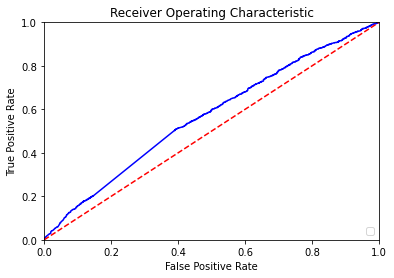

In [156]:
scores = clf_lr.predict_proba(X_pos[col_keep_test])[:,1]
fpr, tpr, thresholds = roc_curve(y_train, scores)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [174]:
thresholds[fpr<0.5][-1]

0.826540905588971

In [175]:
y_pred = clf_lr.predict(X_test[col_keep_test])
y_pred = clf_lr.predict_proba(X_test[col_keep_test])[:,1]
y_pred[y_pred>0.826540905588971] = 1
y_pred[y_pred<1] = 0

In [176]:
confusion_matrix(y_test, y_pred)

array([[1073, 2365],
       [1687, 1416]])

In [177]:
print(
    n,
    f'Accuracy {accuracy_score(y_test, y_pred):.3f}',
    f'Precision {precision_score(y_test, y_pred):.3f}',
    f'Recall {recall_score(y_test, y_pred):.3f}',
    f'F1 Score {f1_score(y_test, y_pred):.3f}',
)

rand_frst Accuracy 0.381 Precision 0.375 Recall 0.456 F1 Score 0.411
